In [1]:
import sys
import time
import random
from mdsthin import MDSplus
import matplotlib.pyplot as plt
import numpy as np
from multiprocessing import Pool
all_shots = [int(line.rstrip()) for line in open('disruption_warnings_all_shots.csv')]

In [5]:
class SigObj:
   def __init__(self, sig_name, tree, signal):
      self.sig_name = sig_name.lower()
      self.tree = tree.lower()
      self.signal = signal.lower()


# Use "raw" strings when entering tag names (so don't have to enter "\\" for "\").
# These four signals were used for initial tests of the program.
#            SigObj("ip", "cmod", r"\Ip"),
#            SigObj("efit_aminor", "cmod", r"\efit_aeqdsk:aminor"), 
#            SigObj("bolo_bright", "spectroscopy", "BOLOMETER.RESULTS.DIODE.AXA:BRIGHT"),
#            SigObj("xtomo_chord16", "xtomo", "BRIGHTNESSES.ARRAY_1:CHORD_16")

# These ~70 signals are most of those that disruption-py retrieves by default.
signals = [ 
            SigObj("mflux_v0", "analysis", r"\top.mflux:v0"),
            SigObj("aeqdsk_time", "cmod", r"\analysis::efit_aeqdsk:time"),
            SigObj("aeqdsk_aminor", "cmod", r"\efit_aeqdsk:aminor"),
            SigObj("aeqdsk_area", "cmod", r"\efit_aeqdsk:area"),
            SigObj("aeqdsk_betan", "cmod", r"\efit_aeqdsk:betan"),
            SigObj("aeqdsk_betap", "cmod", r"\efit_aeqdsk:betap"),
            SigObj("aeqdsk_chisq", "cmod", r"\efit_aeqdsk:chisq"),
            SigObj("aeqdsk_doutl", "cmod", r"\efit_aeqdsk:doutl"),
            SigObj("aeqdsk_doutu", "cmod", r"\efit_aeqdsk:doutu"),
            SigObj("aeqdsk_eout", "cmod", r"\efit_aeqdsk:eout"),
            SigObj("aeqdsk_kappa", "cmod", r"\efit_aeqdsk:kappa"),
            SigObj("aeqdsk_li", "cmod", r"\efit_aeqdsk:li"),
            SigObj("aeqdsk_obott", "cmod", r"\efit_aeqdsk:obott/100"),
            SigObj("aeqdsk_otop", "cmod", r"\efit_aeqdsk:otop/100"),
            SigObj("aeqdsk_q0", "cmod", r"\efit_aeqdsk:q0"),
            SigObj("aeqdsk_q95", "cmod", r"\efit_aeqdsk:q95"),
            SigObj("aeqdsk_qstar", "cmod", r"\efit_aeqdsk:qstar"),
            SigObj("aeqdsk_rmagx", "cmod", r"\efit_aeqdsk:rmagx"),
            SigObj("aeqdsk_ssep", "cmod", r"\efit_aeqdsk:ssep/100"),
            SigObj("aeqdsk_time2", "cmod", r"\efit_aeqdsk:time"),
            SigObj("aeqdsk_vloopt", "cmod", r"\efit_aeqdsk:vloopt"),
            SigObj("aeqdsk_wplasm", "cmod", r"\efit_aeqdsk:wplasm"),
            SigObj("aeqdsk_xnnc", "cmod", r"-\efit_aeqdsk:xnnc"),
            SigObj("aeqdsk_zmagx", "cmod", r"\efit_aeqdsk:zmagx"),
            SigObj("aeqdsk_ssibry", "cmod", r"\efit_geqdsk:ssibry"),
            SigObj("electrons_fiberz", "electrons", r"\fiber_z"),
            SigObj("electrons_nl04", "electrons", r"\electrons::top.tci.results:nl_04"),
            SigObj("electrons_te_rz", "electrons", r"\electrons::top.yag_new.results.profiles:te_rz"),
            SigObj("electrons_zsrt", "electrons", r"\electrons::top.yag_new.results.profiles:z_sorted"),
            SigObj("eng_r_cur", "engineering", r"\efc:u_bus_r_cur"),
            SigObj("hybrid_s1p2_factor", "dpcs", r"\dpcs::top.seg_01:p_02:predictor:factor"),
            SigObj("hybrid_s2p2_factor", "dpcs", r"\dpcs::top.seg_02:p_02:predictor:factor"),
            SigObj("hybrid_in056_p2v", "hybrid", r"\hybrid::top.dpcs_config.inputs:input_056:p_to_v_expr"),
            SigObj("hybrid_in056", "hybrid", r"\hybrid::top.hardware.dpcs.signals.a_in:input_056"),
            SigObj("hybrid_aout", "hybrid", r"\top.hardware.dpcs.signals:a_out"),
            SigObj("lh_netpow", "LH", r"\LH::TOP.RESULTS:NETPOW"),
            SigObj("mag_btor", "magnetics", r"\btor"),
            SigObj("mag_ip", "magnetics", r"\ip"),
            SigObj("mag_pickup", "magnetics", r"\mag_bp_coils.btor_pickup"),
            SigObj("mag_nodename", "magnetics", r"\mag_bp_coils.nodename"),
            SigObj("mag_phi", "magnetics", r"\mag_bp_coils.phi"),
            SigObj("mag_bp13bc", "magnetics", r"\mag_bp_coils.signals.BP13_BC"),
            SigObj("mag_bp13de", "magnetics", r"\mag_bp_coils.signals.BP13_DE"),
            SigObj("mag_bp13gh", "magnetics", r"\mag_bp_coils.signals.BP13_GH"),
            SigObj("mag_bp13jk", "magnetics", r"\mag_bp_coils.signals.BP13_JK"),
            SigObj("cmod_ts_te", "cmod", r"\ts_te"),
            SigObj("pcs_s1p01_name", "pcs", r"\PCS::TOP.SEG_01:P_01:name"),
            SigObj("pcs_s1p02", "pcs", r"\PCS::TOP.SEG_01:P_02"),
            SigObj("pcs_s1p02_name", "pcs", r"\PCS::TOP.SEG_01:P_02:name"),
            SigObj("pcs_s1p02_pid", "pcs", r"\PCS::TOP.SEG_01:P_02:pid_gains"),
            SigObj("pcs_s1p16_name", "pcs", r"\PCS::TOP.SEG_01:P_16:name"),
            SigObj("pcs_s1p16_pid", "pcs", r"\PCS::TOP.SEG_01:P_16:pid_gains"),
            SigObj("pcs_s1start", "pcs", r"\PCS::TOP.SEG_01:start_time"),
            SigObj("pcs_s2p01_name", "pcs", r"\PCS::TOP.SEG_02:P_01:name"),
            SigObj("pcs_s2p02", "pcs", r"\PCS::TOP.SEG_02:P_02"),
            SigObj("pcs_s2p02_name", "pcs", r"\PCS::TOP.SEG_02:P_02:name"),
            SigObj("pcs_s2p02_pid", "pcs", r"\PCS::TOP.SEG_02:P_02:pid_gains"),
            SigObj("pcs_s2p16", "pcs", r"\PCS::TOP.SEG_02:P_16"),
            SigObj("pcs_s2p16_name", "pcs", r"\PCS::TOP.SEG_02:P_16:name"),
            SigObj("pcs_s2p16_pid", "pcs", r"\PCS::TOP.SEG_02:P_16:pid_gains"),
            SigObj("pcs_s2start", "pcs", r"\PCS::TOP.SEG_02:start_time"),
            SigObj("rf_power", "RF", r"\rf::rf_power_net"),
            SigObj("bolo_axa_good", "spectroscopy", r"\SPECTROSCOPY::TOP.BOLOMETER.DIODE_CALIB.AXA:GOOD"),
            SigObj("bolo_axa_zo", "spectroscopy", r"\SPECTROSCOPY::TOP.BOLOMETER.DIODE_CALIB.AXA:Z_O"),
            SigObj("bolo_axj_good", "spectroscopy", r"\SPECTROSCOPY::TOP.BOLOMETER.DIODE_CALIB.AXJ:GOOD"),
            SigObj("bolo_axj_zo", "spectroscopy", r"\SPECTROSCOPY::TOP.BOLOMETER.DIODE_CALIB.AXJ:Z_O"),
            SigObj("bolo_axa_bright", "spectroscopy", r"\SPECTROSCOPY::TOP.BOLOMETER.RESULTS.DIODE.AXA:BRIGHT"),
            SigObj("bolo_axj_bright", "spectroscopy", r"\SPECTROSCOPY::TOP.BOLOMETER.RESULTS.DIODE.AXJ:BRIGHT"),
            SigObj("spect_twopi", "spectroscopy", r"\twopi_diode"),
            SigObj("xtomo_chord16", "xtomo", r"\top.brightnesses.array_1:chord_16")
         ]


In [11]:
# need to do this to drop the caches sudo /usr/bin/echo 3 | sudo /usr/bin/tee /proc/sys/vm/drop_caches

In [47]:
def bench(shots):
#    import time
#    print(f'bench({len(shots)})')
    c = MDSplus.Connection('alcdata-archives')
#    dummy = c.get('setenv("PyLib=python2.7")')
#    dummy = c.get('shorten_path()')
#    print('loop through shots')
    for shot in shots:
#        print(f'working on {shot}')
        c.openTree('cmod', shot)
#        print('treeopen')
        for s in signals:
            try:
                y = c.get(f'_sig = {s.signal}')
                x = c.get('dim_of(_sig)')
            except Exception as e:
#                print(f'could not read {s.signal} from {shot}')
#                print(e)
                pass

def test(shots, threads):
    slop = len(shots) % threads
    if slop != 0:
        shots = shots[0:-slop]
    shots = np.array(shots).reshape(threads, int(len(shots)/threads))
    start = time.time()
    with Pool(threads) as p:
        p.map(bench, shots)
    times.append(time.time()-start)
    print(num, times[-1])


In [49]:
times = []
for num in range(1,32):
    test(all_shots[0:500], num)

1 81.94379258155823
2 43.23211312294006
3 21.341783046722412
4 16.880696296691895
5 14.236693143844604
6 12.401867151260376
7 11.081252574920654
8 10.312901496887207
9 9.834455490112305
10 9.285439729690552
11 8.902223825454712
12 8.55430793762207
13 8.5423264503479
14 8.181176662445068
15 7.949551820755005
16 7.983365058898926
17 8.228273391723633
18 7.5759594440460205
19 7.463629961013794
20 7.554784536361694
21 7.211082458496094
22 7.325140953063965
23 7.145150423049927
24 7.3040711879730225
25 9.30954098701477
26 16.560960292816162
27 7.899668455123901
28 7.811370849609375
29 7.63704514503479
30 7.466955184936523
31 9.448761940002441


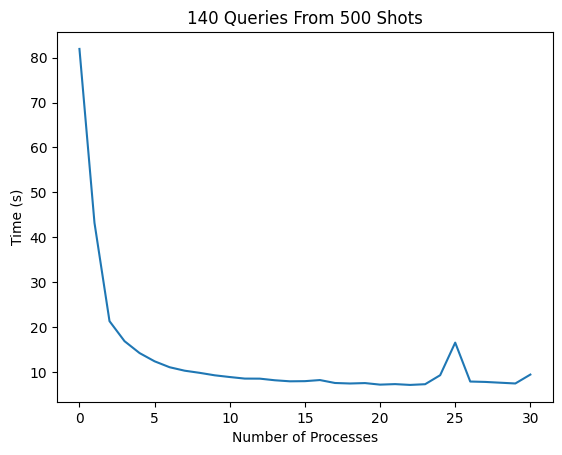

In [50]:
thin_times = times
plt.plot(thin_times)
plt.title('140 Queries From 500 Shots')
plt.xlabel('Number of Processes')
plt.ylabel('Time (s)')
plt.show()

In [22]:
def bench(shots):
#    import time
#    print(f'bench({len(shots)})')
    c = MDSplus.Connection('alcdata')
#    dummy = c.get('setenv("PyLib=python2.7")')
#    dummy = c.get('shorten_path()')
#    print('loop through shots')
    for shot in shots:
#        print(f'working on {shot}')
        c.openTree('cmod', shot)
#        print('treeopen')
        for s in signals:
            try:
                y = c.get(f'_sig = {s.signal}')
                x = c.get('dim_of(_sig)')
            except Exception as e:
#                print(f'could not read {s.signal} from {shot}')
#                print(e)
                pass

def test(shots, threads):
    slop = len(shots) % threads
    if slop != 0:
        shots = shots[0:-slop]
    shots = np.array(shots).reshape(threads, int(len(shots)/threads))
    start = time.time()
    with Pool(threads) as p:
        p.map(bench, shots)
    times.append(time.time()-start)
    print(num, times[-1])


In [23]:
times = []
for num in range(1,32):
    test(all_shots[0:500], num)

1 489.89630365371704
2 248.53344917297363
3 164.17957401275635
4 128.99212098121643
5 101.22375321388245
6 96.70812845230103
7 72.95981097221375
8 72.46914672851562
9 65.64399814605713
10 55.85127067565918
11 44.76167607307434
12 41.06734561920166
13 35.4787015914917
14 35.53275275230408
15 29.430649518966675
16 28.290436506271362
17 27.718876838684082
18 24.35537362098694
19 24.833137035369873
20 26.84561586380005
21 24.005409955978394
22 24.222277402877808
23 23.58484935760498
24 26.415690898895264
25 28.062350749969482
26 23.40546941757202
27 26.72419285774231
28 23.640560388565063
29 21.708654642105103
30 21.84907817840576
31 21.1685049533844


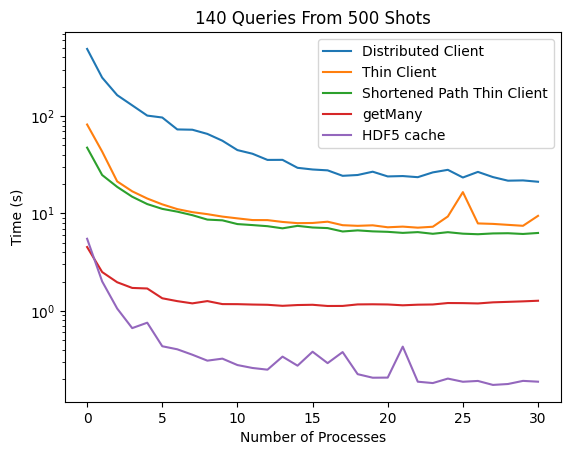

In [5]:
plt.plot(stats['distributed_times'], label='Distributed Client')
plt.plot(stats['thin_times'], label='Thin Client')
plt.plot(stats['shortened_times'], label='Shortened Path Thin Client')
plt.plot(stats['getmany_times'], label='getMany')
plt.plot(stats['hdf_times'], label='HDF5 cache')
plt.yscale('log')
plt.title('140 Queries From 500 Shots')
plt.xlabel('Number of Processes')
plt.ylabel('Time (s)')
plt.legend()


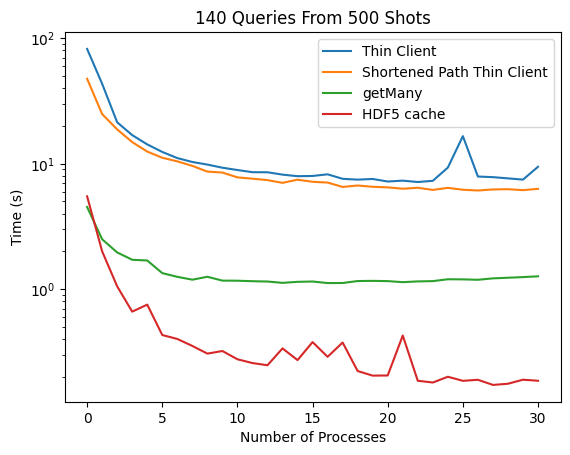

In [26]:
plt.plot(stats['thin_times'], label='Thin Client')
plt.plot(stats['shortened_times'], label='Shortened Path Thin Client')
plt.plot(stats['getmany_times'], label='getMany')
plt.plot(stats['hdf_times'], label='HDF5 cache')
plt.title('140 Queries From 500 Shots')
plt.xlabel('Number of Processes')
plt.ylabel('Time (s)')
plt.yscale('log')
plt.legend()


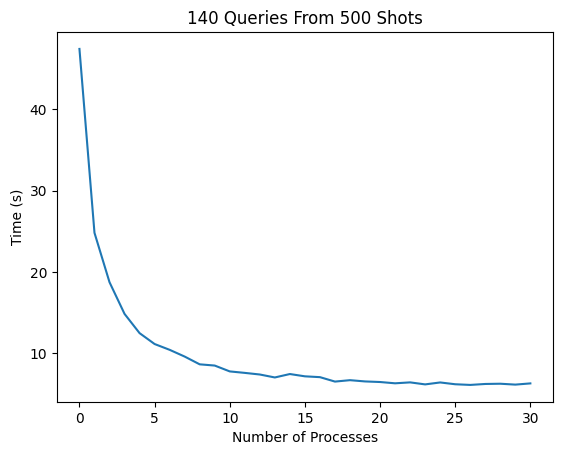

In [31]:
thin_times = times
plt.plot(times_thin)
plt.title('140 Queries From 500 Shots')
plt.xlabel('Number of Processes')
plt.ylabel('Time (s)')
plt.show()

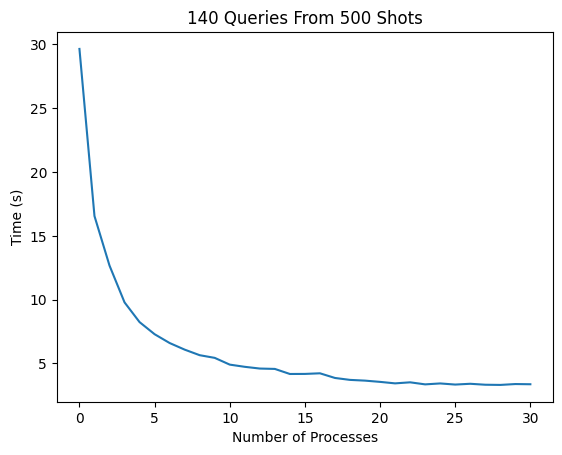

In [10]:
times_thin_shortened = times
plt.plot(times_thin_shortened)
plt.title('140 Queries From 500 Shots')
plt.xlabel('Number of Processes')
plt.ylabel('Time (s)')
plt.show()

In [14]:
import pickle

In [17]:
with open('mfews-garnier-bench','wb') as f:
    pickle.dump(all_shots,f)
    pickle.dump(signals,f)
    pickle.dump(times_distributed,f)
    pickle.dump(times_thin_shortened,f)


In [32]:
def gm_bench(shots):
#    import time
#    print(f'bench({len(shots)})')
    c = MDSplus.Connection('alcdata-archives')
    dummy = c.get('setenv("PyLib=python2.7")')
    dummy = c.get('shorten_path()')
    gm = c.getMany()
    for signal in signals:
        gm.append(signal.sig_name,f'_sig={signal.signal}')
        gm.append(f'{signal.sig_name}_time', 'dim_of(_sig)')   
#    print('loop through shots')
    for shot in shots:
        ans = gm.execute()

def gm_test(shots, threads):
    slop = len(shots) % threads
    if slop != 0:
        shots = shots[0:-slop]
    shots = np.array(shots).reshape(threads, int(len(shots)/threads))
    start = time.time()
    with Pool(threads) as p:
        p.map(gm_bench, shots)
    gm_times.append(time.time()-start)
    print(num, gm_times[-1])


In [33]:
gm_times=[]
for num in range(1,32):
    gm_test(all_shots[0:500], num)

1 4.519117116928101
2 2.5011491775512695
3 1.9650065898895264
4 1.717653751373291
5 1.6953356266021729
6 1.3448894023895264
7 1.2568435668945312
8 1.1924934387207031
9 1.258148193359375
10 1.1720211505889893
11 1.1701796054840088
12 1.1596126556396484
13 1.152996301651001
14 1.1250970363616943
15 1.1461734771728516
16 1.1532371044158936
17 1.120734453201294
18 1.122145652770996
19 1.163205862045288
20 1.1668014526367188
21 1.161517858505249
22 1.1391546726226807
23 1.1556286811828613
24 1.161414384841919
25 1.2019269466400146
26 1.1994049549102783
27 1.1902697086334229
28 1.221595048904419
29 1.2356390953063965
30 1.250422477722168
31 1.2686960697174072


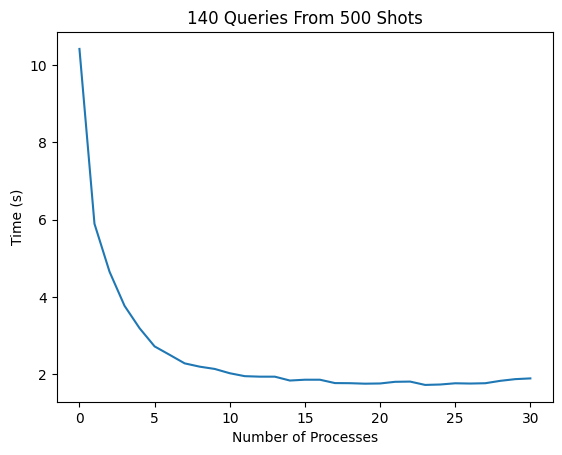

In [16]:
times_gm = gm_times
plt.plot(times_gm)
plt.title('140 Queries From 500 Shots')
plt.xlabel('Number of Processes')
plt.ylabel('Time (s)')
plt.show()

In [18]:
import pickle
with open('mfews-fsantoro-shortened-getmany','wb') as f:
    pickle.dump(all_shots,f)
    pickle.dump(signals,f)
    pickle.dump(gm_times,f)


In [12]:
# now write hdf5 files 1 file per shot
def hdf_store(shots):
    import h5py
    c = MDSplus.Connection('alcdata-archives')
    dummy = c.get('setenv("PyLib=python2.7")')
    dummy = c.get('shorten_path()')
    gm = c.getMany()
    for signal in signals:
        gm.append(signal.sig_name,f'_sig={signal.signal}')
        gm.append(f'{signal.sig_name}_time', 'dim_of(_sig)')   
    
    for shot in shots:
        c.openTree('cmod', shot)
        ans = gm.execute()
        with h5py.File(f'hdf/{shot}.hdf5', 'w') as f:
            for key in ans.keys():
                try:
                    f.create_dataset(key, data=ans[key]['value'])
                except:
                    pass



In [9]:
import h5py
import time
import MDSplus


In [10]:
c = MDSplus.Connection('alcdata-archives')
dummy = c.get('setenv("PyLib=python2.7")')
dummy = c.get('shorten_path()')
gm = c.getMany()
for signal in signals:
    gm.append(signal.sig_name,f'_sig={signal.signal}')
    gm.append(f'{signal.sig_name}_time', 'dim_of(_sig)') 
c.openTree('cmod', all_shots[2000])
ans = gm.execute()


In [16]:
start=time.time()
hdf_store(all_shots)
print(f"Write 10K shots into 1 file took {time.time()-start} seconds")

Write 10K shots into 1 file took 9189.839812994003 seconds


In [15]:
# now write hdf5 files 1 file with all the shots
def hdf_store(shots):
    import h5py
    c = MDSplus.Connection('alcdata-archives')
    dummy = c.get('setenv("PyLib=python2.7")')
    dummy = c.get('shorten_path()')
    gm = c.getMany()
    for signal in signals:
        gm.append(signal.sig_name,f'_sig={signal.signal}')
        gm.append(f'{signal.sig_name}_time', 'dim_of(_sig)')   
    
    cnt = 0
    with h5py.File(f'/home/jas/hdf/all_shots.hdf5', 'w', fs_strategy='page', fs_page_size=8_000_000) as f:
        for shot in shots:
            cnt += 1
            if cnt % 1000 == 0:
                print(f'{cnt} shots done')
            try:
                c.openTree('cmod', shot)
                ans = gm.execute()
                group = f.create_group(str(shot))
                for key in ans.keys():
                    try:
                        group.create_dataset(key, data=ans[key]['value'])
                    except:
                        pass
            except Exception as e:
                print(f'Problem with shot {shot}')



In [10]:
import MDSplus
c = MDSplus.Connection('alcdata-archives')
c.openTree('cmod', 1050218020)
t = MDSplus.Tree('cmod', 1050218020)

In [16]:
import time
start = time.time()
hdf_store(all_shots)
print(f"Write 10K shots into 1 file took {time.time()-start} seconds")

1000 shots done
2000 shots done
3000 shots done
4000 shots done
5000 shots done
6000 shots done
7000 shots done
8000 shots done
9000 shots done
10000 shots done
Write 10K shots into 1 file took 9054.395299196243 seconds


In [8]:
# can not do multi threaded writes
threads = 1
shots = all_shots
slop = len(shots) % threads
if slop != 0:
    shots = shots[0:-slop]
shots = np.array(shots).reshape(threads, int(len(shots)/threads))
start = time.time()
with Pool(threads) as p:
    p.map(hdf_store, shots)
print(f"Write 10K shots into 1 file took {time.time()-start} seconds")

ValueError: buffer is smaller than requested size

In [16]:
threads = 10
shots = all_shots[0:500]
slop = len(shots) % threads
if slop != 0:
    shots = shots[0:-slop]
shots = np.array(shots).reshape(threads, int(len(shots)/threads))
start = time.time()
with Pool(threads) as p:
    p.map(hdf_store, shots)

In [37]:
import h5py
def hdf_bench(shots):
    for shot in shots:
        with h5py.File(f'hdf/{shot}.hdf5', 'r') as f:
            for s in signals:
                try:
                    y = f['{s}']
                    x = f['{s}_time']
                except:
                    pass

def hdf_test(shots, threads):
    slop = len(shots) % threads
    if slop != 0:
        shots = shots[0:-slop]
    shots = np.array(shots).reshape(threads, int(len(shots)/threads))
    start = time.time()
    with Pool(threads) as p:
        p.map(hdf_bench, shots)
    hdf_times.append(time.time()-start)
    print(threads,hdf_times[-1])


In [38]:
hdf_times = []
for num in range(1, 32):
    hdf_test(all_shots[0:500], num)

1 5.496341705322266
2 2.005189895629883
3 1.0549466609954834
4 0.6638858318328857
5 0.7548980712890625
6 0.43244075775146484
7 0.4023153781890869
8 0.35402607917785645
9 0.30756378173828125
10 0.3225688934326172
11 0.27722597122192383
12 0.2586655616760254
13 0.24849319458007812
14 0.33834266662597656
15 0.2731039524078369
16 0.37987208366394043
17 0.29006505012512207
18 0.37679362297058105
19 0.22344088554382324
20 0.20543885231018066
21 0.20600605010986328
22 0.4285762310028076
23 0.18699240684509277
24 0.18102288246154785
25 0.20123600959777832
26 0.1867063045501709
27 0.19034242630004883
28 0.1732466220855713
29 0.17703914642333984
30 0.19064021110534668
31 0.18701887130737305


In [22]:
stats.keys()

dict_keys(['all_shots', 'distributed_times', 'thin_times', 'shortened_times', 'getmany_times', 'hdf_times'])

Text(0, 0.5, 'Time (s)')

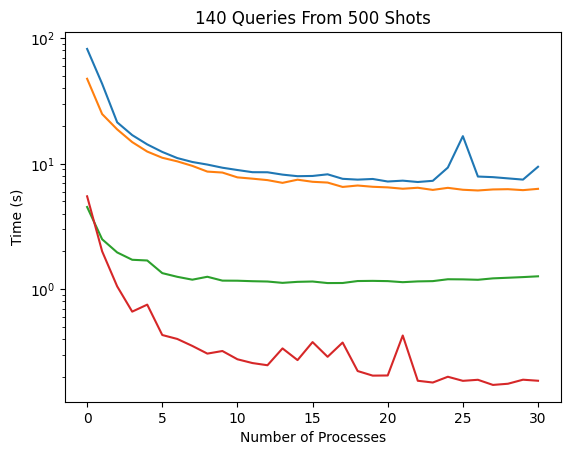

In [25]:
plt.plot(stats['thin_times'])
plt.plot(stats['shortened_times'])
plt.plot(stats['getmany_times'])
plt.plot(stats['hdf_times'])
plt.title('140 Queries From 500 Shots')
plt.xlabel('Number of Processes')
plt.yscale('log')
plt.ylabel('Time (s)')

In [17]:
import pickle
with open('mfews-fsantoro-shortened-getmany','rb') as f:
    data=pickle.load(f)

In [ ]:

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('exp', color=color)
ax1.plot(t, data1, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('sin', color=color)  # we already handled the x-label with ax1
ax2.plot(t, data2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [46]:
shortened_times = times_thin

In [61]:
saved_stats = {
    'all_shots':all_shots,
    'distributed_times':distributed_times,
    'thin_times':thin_times,
    'shortened_times': shortened_times,
    'getmany_times':gm_times,
    'hdf_times': hdf_times
}


In [62]:
with open('saved_stats.pkl','wb') as f:
    pickle.dump(saved_stats, f)

In [18]:
import pickle
with open('saved_stats.pkl','rb') as f:
    stats = pickle.load(f)

In [19]:
s = stats
import csv
with open('paper-data.csv', 'w', newline='') as f:
    w = csv.writer(f)
    w.writerow(s.keys())
    w.writerows(s.items())
#with open('paper-data.csv', 'w') as f:
#    print(

In [59]:
print(stats['distributed_times'])

[489.89630365371704, 248.53344917297363, 164.17957401275635, 128.99212098121643, 101.22375321388245, 96.70812845230103, 72.95981097221375, 72.46914672851562, 65.64399814605713, 55.85127067565918, 44.76167607307434, 41.06734561920166, 35.4787015914917, 35.53275275230408, 29.430649518966675, 28.290436506271362, 27.718876838684082, 24.35537362098694, 24.833137035369873, 26.84561586380005, 24.005409955978394, 24.222277402877808, 23.58484935760498, 26.415690898895264, 28.062350749969482, 23.40546941757202, 26.72419285774231, 23.640560388565063, 21.708654642105103, 21.84907817840576, 21.1685049533844]


In [60]:
distributed_times = stats['distributed_times']

In [10]:
import pandas

In [12]:
#help(pandas.read_pickle)
df = pandas.DataFrame(s)

In [13]:
df

,distributed_times,thin_times,shortened_times,getmany_times,hdf_times
0,489.896304,81.943793,47.422873,4.519117,5.496342
1,248.533449,43.232113,24.817130,2.501149,2.005190
2,164.179574,21.341783,18.744510,1.965007,1.054947
3,128.992121,16.880696,14.849768,1.717654,0.663886
4,101.223753,14.236693,12.483907,1.695336,0.754898
5,96.708128,12.401867,11.145935,1.344889,0.432441
6,72.959811,11.081253,10.432460,1.256844,0.402315
7,72.469147,10.312901,9.603370,1.192493,0.354026
8,65.643998,9.834455,8.648934,1.258148,0.307564
9,55.851271,9.285440,8.498308,1.172021,0.322569


In [14]:
df.to_csv('test.csv')